# Movie Recommendations

[Recommender System](https://en.wikipedia.org/wiki/Recommender_system) is a system that predict ratings or preferences user may give to this item. It is a method to recommend things to people based on their past behaviour.We often sort or present as "top-N" recommendations which means recommendating people a set of N items from a large collection of items. In this method, there are many metrics to evaluate the results.

The following metrics are commonly used for ranking evaluation of top-n recommender systems:
* Mean Absoulte Error (MAE): It is the difference between actual values and predicted values.
> MAE = $\displaystyle \frac{\sum_{i=1}^{n} |y_i-\hat{y_i}|}{n}$
* Root Mean Square Error (RMSE): It is similar to MAE but it squared the residual then square root the whole term.
> RMSE = $\displaystyle \sqrt{\frac{\sum_{i=1}^{n} (y_i-\hat{y_i})^2}{n}}$
* Hit Rate: After generating top-n recommendations for all of the users in testset if one of the recommendations in a user's top-n recommendations is something they actually rated then we consider that is a hit.
> Hit Rate = The number of hit / the number of user
* Average Reciporocal Hit Rank (ARHR):
> ARHR = $\displaystyle \frac{\sum_{i=1}^{hit} \displaystyle \frac{1}{rank_i}}{users}$
* Cumulative Hit Rate (CHR): It is similar to the hit rate that shown above but we add a threshold for the test set so that we test on the movies that the person actually likes.
* Coverage: That is the percentage of possible recommendations that system is able to provide.
* Diversity: It is a measure of how broad a variety of recommending items.
* Novelty: It is a measure of how popular are the items that system is recommending.

In this project, we mainly use `surprise module` to build differnent recommender system to predict moving rating and provide recommendations.

## Table of Contents

1. [Exploratory Data Analysis](#eda)
    - 1.1 [Loading Data](#eda_loading_data)
    - 1.2 [Genres](#eda_genres)
    - 1.3 [Ratings](#eda_ratings)
    - 1.4 [Years](#eda_years)
2. [Building Models](#building_model)
    - 2.1 [Loading Data](#m_loading_data)
    - 2.2 [Pre-processing](#m_pre_processing)
        - [Extract Information](#m_extract_information)
        - [Extra Function](#m_extra_functionn)
        - [Get Evaluation Dataset](#m_get_evaluation_dataset)
        - [Evaluation Metrics](#m_evaluation_metrics)
    - 2.3 [Algorithm](#m_algorithm)
        - [SVD](#m_svd)
        - [User-Based KNN](#m_userknn)
        - [Item-Based KNN](#m_itemknn)
        - [Restricted Boltzmann Machines](#m_rbm)
        - [AutoEncoder](#m_ae)

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from collections import defaultdict
import re
import itertools
import surprise
from surprise import Dataset, Reader
from surprise import AlgoBase, PredictionImpossible
from surprise import SVD, KNNBasic, KNNBaseline, accuracy
from surprise.model_selection import train_test_split, LeaveOneOut, GridSearchCV
import tensorflow as tf


/kaggle/input/movielens/movies.csv
/kaggle/input/movielens/ratings.csv
/kaggle/input/movielens/README.txt
/kaggle/input/movielens/tags.csv
/kaggle/input/movielens/links.csv


## 1. <a id='eda'></a>Exploratory Data Analysis

### <a id='eda_loading_data'></a>1.1 Loading Data

In [2]:
# Loading dataset
df_movies = pd.read_csv('../input/movielens/movies.csv')
df_ratings = pd.read_csv('../input/movielens/ratings.csv')

In [3]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


We can see that there is no missing data in `ratings.csv` file and the range of rating is between 0.5 and 5.

### <a id='eda_genres'></a>1.2 Genres

In [6]:
genres = df_movies['genres'].str.get_dummies(sep='|')
genres_count = genres.sum(axis = 0).to_frame().reset_index()
genres_count.columns =['genres', 'count']
genres_count = genres_count.sort_values(by='count', ascending=False)
print('The total number of genres is:', genres_count.shape[0])
genres_count['percentage(%)'] = round(genres_count['count']/sum(genres_count['count']), 4)*100
genres_count

The total number of genres is: 20


,genres,count,percentage(%)
8,Drama,4365,21.46
5,Comedy,3315,16.30
17,Thriller,1729,8.50
1,Action,1545,7.60
15,Romance,1545,7.60
2,Adventure,1117,5.49
6,Crime,1100,5.41
11,Horror,877,4.31
16,Sci-Fi,792,3.89
9,Fantasy,654,3.22


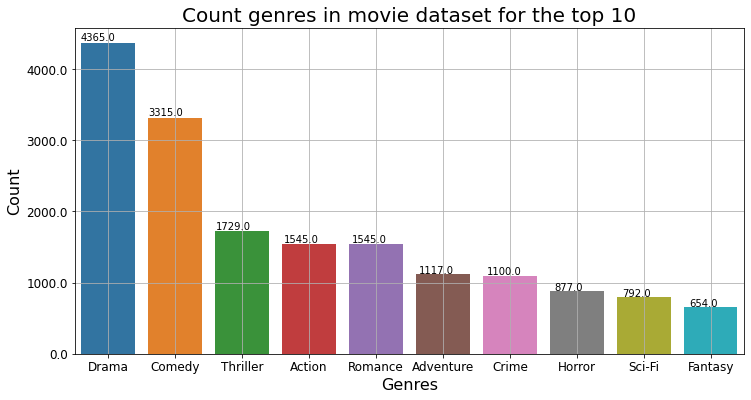

In [7]:
# plot the distribution of genres and we only show top 10
plt.figure(figsize = (12, 6))
ax = sns.barplot(genres_count['genres'][:10], genres_count['count'][:10], palette="tab10")
for q in ax.patches:
    ax.annotate(str(q.get_height()), (q.get_x() * 1.01 , q.get_height() * 1.01))
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 12)
plt.title("Count genres in movie dataset for the top 10", fontsize = 20)
plt.xlabel("Genres", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.grid()

We can see that there are 20 different kinds of genres and drama and comedy are biggest genres in `movies.csv` file.

### <a id='eda_ratings'></a>1.3 Ratings

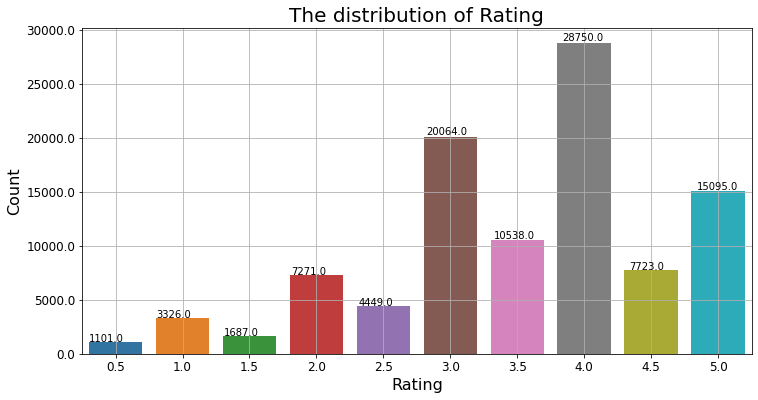

In [8]:
# merge `ratings.csv` and `movies.csv` by movieID
df = pd.merge(df_ratings, df_movies, how='left', on='movieId')
rating_count = df['rating'].value_counts().to_frame().reset_index()
rating_count.columns =['rating', 'count']
rating_count = rating_count.sort_values(by='count', ascending=False)

# plot the distribution of rating
plt.figure(figsize = (12, 6))
ax = sns.barplot(rating_count['rating'], rating_count['count'], palette="tab10")
for q in ax.patches:
    ax.annotate(str(q.get_height()), (q.get_x() * 1.01 , q.get_height() * 1.01))
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 12)
plt.title("The distribution of Rating", fontsize = 20)
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.grid()

In [9]:
rating_count['percentage(%)'] = round(rating_count['count']/sum(rating_count['count']), 4)*100
rating_count

,rating,count,percentage(%)
0,4.0,28750,28.75
1,3.0,20064,20.06
2,5.0,15095,15.09
3,3.5,10538,10.54
4,4.5,7723,7.72
5,2.0,7271,7.27
6,2.5,4449,4.45
7,1.0,3326,3.33
8,1.5,1687,1.69
9,0.5,1101,1.10


Most users give 3 or 4 to movie.

In [10]:
sum_rating = df.groupby(['movieId', 'title'], as_index=False)['rating'].sum().rename(columns={'rating':'sum'}).sort_values(by='sum', ascending=False)
num_rating = df.groupby(['movieId'])['title'].count().to_frame().reset_index().rename(columns={'title':'num_of_rating'})
detail_rating = pd.merge(sum_rating, num_rating, how='left', on='movieId')
detail_rating['average_rating'] = detail_rating['sum']/detail_rating['num_of_rating']

# Show the top 5 sum of rating
detail_rating.iloc[:5]

,movieId,title,sum,num_of_rating,average_rating
0,318,"Shawshank Redemption, The (1994)",1395.5,311,4.487138
1,356,Forrest Gump (1994),1382.5,341,4.054252
2,296,Pulp Fiction (1994),1379.0,324,4.256173
3,593,"Silence of the Lambs, The (1991)",1258.0,304,4.138158
4,260,Star Wars: Episode IV - A New Hope (1977),1228.5,291,4.221649


In [11]:
# Show the top 5 number of rating
detail_rating.sort_values(by='num_of_rating', ascending=False).iloc[:5]

,movieId,title,sum,num_of_rating,average_rating
1,356,Forrest Gump (1994),1382.5,341,4.054252
2,296,Pulp Fiction (1994),1379.0,324,4.256173
0,318,"Shawshank Redemption, The (1994)",1395.5,311,4.487138
3,593,"Silence of the Lambs, The (1991)",1258.0,304,4.138158
4,260,Star Wars: Episode IV - A New Hope (1977),1228.5,291,4.221649


### <a id='eda_years'></a>1.4 Years

The maximum year in this dataset is: 2016
The minimum year in this dataset is: 1902


Text(0, 0.5, 'Count')

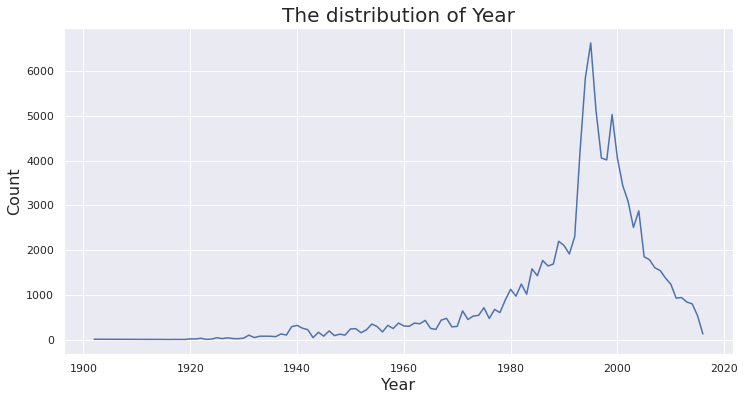

In [12]:
# extract movie's year from dataset
p = re.compile(r"(?:\((\d{4})\))?\s*$")
df_year = []
for row_df in range(df.shape[0]):
    title = df.iloc[row_df]['title']
    extract_year = p.search(title)
    year = extract_year.group(1)
    df_year.append(year)
df['year'] = df_year

# count the number of year
years_count = df['year'].value_counts().to_frame().reset_index()
years_count.columns =['year', 'count']
years_count = years_count.sort_values(by='year', ascending=True)
years_count['percentage(%)'] = round(years_count['count']/sum(years_count['count']), 4)*100
print('The maximum year in this dataset is:', years_count.iloc[-1]['year'])
print('The minimum year in this dataset is:', years_count.iloc[0]['year'])

# plot the distribution of year and we only show top 15
years_count['year'] = pd.to_numeric(years_count['year'])
plt.figure(figsize = (12, 6))
sns.set_theme(style="darkgrid")
ax = sns.lineplot(data=years_count, x='year', y='count')
plt.title("The distribution of Year", fontsize = 20)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Count", fontsize = 16)

We can see that movie's year is between 1905 and 2016 in the dataset and most rated ones is between 1990 and 2005.

## 2. <a id='building_model'></a>Building Models using `surprise module`

### <a id='m_loading_data'></a>2.1 Loading Data

In [13]:
ratingsPath = '../input/movielens/ratings.csv'
moviesPath = '../input/movielens/movies.csv'

ratingsDataset = 0

reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
ratingsDataset = Dataset.load_from_file(ratingsPath, reader=reader)

### <a id='m_pre_processing'></a>2.2 Pre-processing

#### <a id='m_extract_information'></a>Extract information from dataset

In [14]:
# Create lists which can connect movieID and movie title from movie dataset
movieID_to_name = {}
name_to_movieID = {}

with open(moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
    movieReader = csv.reader(csvfile)
    next(movieReader)
    
    for row_movieReader in movieReader:
        movieID = int(row_movieReader[0])
        movieName = row_movieReader[1]

        movieID_to_name[movieID] = movieName
        name_to_movieID[movieName] = movieID

# result:
# movieID_to_name: (movieID, movie title)
# movieID_to_name = {
# 1: 'Toy Story (1995)', 
# 2: 'Jumanji (1995)',
# 3: 'Grumpier Old Men (1995)',...}

# name_to_movieID: (movie title, movieID)
# name_to_movieID = {
# 'Toy Story (1995)': 1,
# 'Jumanji (1995)': 2,
# 'Grumpier Old Men (1995)': 3,...}

# Get the ranking for the rating dataset
counts = defaultdict(int)
rankings = defaultdict(int) # movie ranking

with open(ratingsPath, newline='') as csvfile:
    ratingReader = csv.reader(csvfile)
    next(ratingReader)
    for row_ratingReader in ratingReader:
        movieID = int(row_ratingReader[1])
        counts[movieID] += 1

rank = 1

for movieID, count in sorted(counts.items(), key=lambda x: x[1], reverse = True):
    rankings[movieID] = rank
    rank += 1

# result:
# rankings: (movieID, ranks)
# rankings = {
# 356: 1,
# 296: 2,
# 318: 3,...}

#### <a id='m_extra_functionn'></a>Extra Function

In [15]:
# We create some functions for getting information from dataset and list

def getUserRatings(user):
    # This function can extract user's rating from rating dataset
    # return a list which contain movieID and rating by the user
    userRatings = []
    flag = False
    with open(ratingPath, newline='') as csvfile:
        ratingReader = csv.reader(csvfile)
        next(ratingReader)
        for row_ratingReader in ratingReader:
            userID = int(row_ratingReader[0])
            if (user == userID):
                movieID = int(row_ratingReader[1])
                rating = float(row_ratingReader[2])
                userRatings.append((movieID, rating))
                flag = True
            if(flag and (user != userID)):
                break

def getMovieName(movieID):
    # This function can return movie name from movieID_to_name list by giving movie ID 
    if movieID in movieID_to_name:
        return movieID_to_name[movieID]
    else:
        return 0

def getMovieID(movieName):
    # This function can return movie ID from name_to_movieID list by giving movie name 
    if movieName in name_to_movieID:
        return name_to_movieID[movieName]
    else:
        return 0

#### <a id='m_get_evaluation_dataset'></a>Get Evaluation Dataset

In [16]:
class EvaluationData:
    
    def __init__(self, data):
        
        # build_full_trainset(): do not split the dataset into folds. Build from the whloe dataset
        self.full_train_set = data.build_full_trainset()
        
        # build_anti_testset: return a list that can be used as a testset
        self.full_anti_test_set = self.full_train_set.build_anti_testset()
        
        # split dataset into trainset and testset.
        self.trainset, self.testset = train_test_split(data, test_size=.25, random_state=1)
        
        # cross-validation iterator where each user has exactly one rating in the testset
        leave_one_out = LeaveOneOut(n_splits=1, random_state=1)
        for train, test in leave_one_out.split(data):
            self.leave_one_out_train = train
            self.leave_one_out_test = test
            
        self.leave_one_out_anti_test = self.leave_one_out_train.build_anti_testset()
    
    # this function can return the whole dataset
    def GetFullTrainSet(self):
        return self.full_train_set
    
    # this function can return a list that can be used as a testset
    def GetFullAntiTestSet(self):
        return self.full_anti_test_set
    
    # this function can return a list that can be used as a testset for test_subject
    def GetAntiTestSetUser(self, test_subjest):
        trainset = self.full_train_set
        ratings_mean = trainset.global_mean
        anti_testset = []
        user_inner_id = trainset.to_inner_uid(str(test_subject))
        item = set([item_inner_id for (item_inner_id, rating) in trainset.ur[user_inner_id]])
        anti_testset += [(trainset.to_raw_uid(user_inner_id), 
                          trainset.to_raw_iid(i), ratings_mean) for 
                          i in trainset.all_items() if i not in item]
        return anti_testset
    
    # this function can return the trainset which is splited by the dataset
    def GetTrainSet(self):
        return self.trainset
    
    # this function can return the testset which is splited by the dataset
    def GetTestSet(self):
        return self.testset
    
    # this function can return the trainset which is relevant to leave-one-out cross-validation
    def GetLOOCVTrainSet(self):
        return self.leave_one_out_train
    
    # this function can return the testset which is relevant to leave-one-out cross-validation
    def GetLOOCVTestSet(self):
        return self.leave_one_out_test
    
    # this function can return a list that can be used as a testset
    def GetLOOCVAntiTestSet(self):
        return self.leave_one_out_anti_test

#### <a id='m_evaluation_metrics'></a>Evaluation Metrics

In [17]:
# We create some functions for evaluating the result

class RecommenderMetrics:
    
    def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)
    
    def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)
    
    def GetTopN(predictions, n = 10, minimumRating=4.0):
        topN = defaultdict(list)
        
        for userID, movieID, actualRating, predictedRating, _ in predictions:
            if(predictedRating>=minimumRating):
                topN[int(userID)].append((int(movieID), predictedRating))
                
        for userID, ratings in topN.items():
            ratings.sort(key=lambda x: x[1], reverse = True)
            topN[int(userID)] = ratings[:n]
        
        return topN
    
    def HitRate(topNPredicted, leftOutPredictions):
        hits = 0
        total = 0
        
        for leftOut in leftOutPredictions:
            userID = leftOut[0]
            leftOutmovieID = leftOut[1]
            
            flag = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if(int(leftOutmovieID) == movieID):
                    flag = True
                    break
            if (flag):
                hits += 1
            total += 1
        return hits/total
    
    def CumulativeHitRate(topNPredicted, leftOutPredictions, cuttingrating):
        hits = 0
        total = 0
        
        for userID, leftOutmovieID, actualRating, predictedRating, _ in leftOutPredictions:
            if (predictedRating >= cuttingrating):
                flag = False
                for movieID, predictedRating in topNPredicted[int(userID)]:
                    if (int(leftOutmovieID) == movieID):
                        flag = True
                        break
                if (flag):
                    hits += 1
                total += 1
            
        return hits/total
    
    def RatingHitRate(topNPredicted, leftOutPredictions):
        hits = defaultdict(float)
        total = defaultdict(float)
        
        for userID, leftOutmovieID, actualRating, predictedRating, _ in leftOutPredictions:
            flag = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutmovieID) == movieID):
                    flag = True
                    break
            if (flag):
                hits[actualRating] += 1
            total[actualRating] +=1
        
        for rating in sorted(total.keys()):
            print(rating, hits[rating]/total[rating])
    
    def AverageReciprocalHitRank(topNPredicted, leftOutPredictions):
        summation = 0
        total = 0
        
        for userID, leftOutmovieID, actualRating, predictedRating, _ in leftOutPredictions:
            hitrank = 0
            rank = 0
            for movieID, predictedRating in topNPredicted[int(userID)]:
                rank = rank + 1
                if (int(leftOutmovieID) == movieID):
                    hitrank = rank
                    break
            if (hitrank > 0):
                summation += 1.0/hitrank
            total += 1
            
        return summation/total
        
    def Coverage(topNPredicted, numUser, threshold = 0):
        hits = 0
        for userID in topNPredicted.keys():
            flag = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (predictedRating > threshold):
                    flag = True
                    break
            if (flag):
                hits += 1
        return hits/numUser
    
    def Diversity(topNPredicted, algo):
        n = 0
        total = 0
        sim_matrix = algo.compute_similarities()
        for userID in topNPredicted.keys():
            pairs = itertools.combinations(topNPredicted[userID], 2)
            for pair in pairs:
                movie1 = pair[0][0]
                movie2 = pair[1][0]
                innerID1 = algo.trainset.to_inner_iid(str(movie1))
                innerID2 = algo.trainset.to_inner_iid(str(movie2))
                similarity = sim_matrix[innerID1][innerID2]
                total += similarity
                n += 1
        prob = total / n
        return (1-prob)
    
    def Novelty(topNPredicted, rankings):
        total = 0
        total_rank = 0
        for userID in topNPredicted.keys():
            for rating in topNPredicted[userID]:
                movieID = rating[0]
                rank = rankings[movieID]
                total_rank += rank
                total += 1
        return total_rank/total

In [18]:
# This class will calculate all the metrics including RMSE, MAE, hit rate, cumulative hit rate,
# average reciprocal hit rate, coverage, civersity, novelty from the model

class EvaluatedAlgorithm:
    
    def __init__(self, algorithm, name):
        self.algorithm = algorithm
        self.name = name
    
    def Evaluate(self, data, n):
        self.data = data
        self.n = n
        metrics = {}

        # Calculate RMSE and MAE
        print('Evaluating accuracy...')
        self.algorithm.fit(self.data.GetTrainSet())
        predictions = self.algorithm.test(self.data.GetTestSet())
        metrics['RMSE'] = RecommenderMetrics.RMSE(predictions)
        metrics['MAE'] = RecommenderMetrics.MAE(predictions)
        
        # Calculate hint rate and cumulative hit rate
        print('Evaluating top-N with leave-one-out cross validation...')
        self.algorithm.fit(data.GetLOOCVTrainSet())
        loopredictions = self.algorithm.test(data.GetLOOCVTestSet())
        allpredictions = self.algorithm.test(data.GetLOOCVAntiTestSet())
        topNPredicted = RecommenderMetrics.GetTopN(allpredictions, n, minimumRating=4)
        
        # print('Computing hit-rate and rank metrics...')
        metrics['HitRate'] = RecommenderMetrics.HitRate(topNPredicted, loopredictions)
        metrics['cHitRate'] = RecommenderMetrics.CumulativeHitRate(topNPredicted, loopredictions, cuttingrating=3)
        metrics['ARHR'] = RecommenderMetrics.AverageReciprocalHitRank(topNPredicted, loopredictions)
        
        # print("Computing recommendations with full data set...")
        # self.algorithm.fit(data.GetFullTrainSet())
        # allpredictions = self.algorithm.test(data.GetFullAntiTestSet())
        # topNPredicted = RecommenderMetrics.GetTopN(allpredictions, n)
        
        # print("Analyzing coverage, diversity, and novelty...")
        # metrics["Coverage"] = RecommenderMetrics.Coverage(topNPredicted, data.GetFullTrainSet().n_users, threshold = 4.0)
        # sim_options = {'name': 'cosine', 'user_based': False}
        # simsAlgo = KNNBaseline(sim_options=sim_options)
        # simsAlgo.fit(data.GetFullTrainSet())
        # metrics["Diversity"] = RecommenderMetrics.Diversity(topNPredicted, simsAlgo)
        # metrics["Novelty"] = RecommenderMetrics.Novelty(topNPredicted, rankings)
        
        print('{:<10} {:<10} {:<10} {:<10} {:<10} {:<10}'.format('Algorithm', 'RMSE', 'MAE', 'HitRate', 'cHitRate', 'ARHR'))
        print('{:<10} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}'.format(self.name, metrics['RMSE'], metrics['MAE'], metrics['HitRate'], metrics['cHitRate'], metrics['ARHR']))
    
    def SampleTopRec(self, test_subject, k):
        self.test_subject = test_subject
        self.k = k
        print('Using recommender', self.name)
        trainSet = self.data.GetTrainSet()
        testSet = self.data.GetAntiTestSetUser(test_subject)
        model = self.algorithm.fit(trainSet)
        predictions = model.test(testSet)

        recommendations = []
        for userID, movieID, actualRating, predictedRating, _ in predictions:
            recommendations.append((int(movieID), predictedRating))
            recommendations.sort(key=lambda x: x[1], reverse=True)
        for row_recommendations in recommendations[:self.k]:
            print(getMovieName(row_recommendations[0]), round(row_recommendations[1], 3))
        

### <a id='m_algorithm'></a>2.3 Algorithm

### <a id='m_svd'></a>**SVD**

[Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) is a matrix factorisation technique, which can reduce the number of featuresof data by reducing the space diemensions. In recommender system, SVD is usually used as collaborative filtering. [Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) is a method to predict the interests of a user by using their past history.

#### Building Model

In [19]:
num_topn = 10
data = EvaluationData(ratingsDataset)
SVDAlgorithm = SVD(random_state=10)
result_SVD = EvaluatedAlgorithm(SVDAlgorithm, 'SVD')
result_SVD.Evaluate(data, num_topn)

Evaluating accuracy...
Evaluating top-N with leave-one-out cross validation...
Algorithm  RMSE       MAE        HitRate    cHitRate   ARHR      
SVD        0.9034     0.6978     0.0298     0.0340     0.0112    


#### Recommend a list for a user

In [20]:
test_subject = 85
num_rec = 10
result_SVD.SampleTopRec(test_subject, num_rec)

Using recommender SVD
All About Eve (1950) 4.472
Lord of the Rings: The Fellowship of the Ring, The (2001) 4.41
Lord of the Rings: The Two Towers, The (2002) 4.383
Lawrence of Arabia (1962) 4.356
Princess Bride, The (1987) 4.337
Casablanca (1942) 4.327
Crimes and Misdemeanors (1989) 4.325
American History X (1998) 4.321
Roman Holiday (1953) 4.318
Spirited Away (Sen to Chihiro no kamikakushi) (2001) 4.314


#### Tune algorithm parameters

In [21]:
dataset = ratingsDataset
param_grid = {'n_epochs': [20, 30], 
              'lr_all': [0.005, 0.01], 
              'n_factors': [50, 100]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(dataset)
print('Best RMSE score is:', gs.best_score['rmse'])
print('The parameters is:', gs.best_params['rmse'])

Best RMSE score is: 0.9002787805185215
The parameters is: {'n_epochs': 20, 'lr_all': 0.005, 'n_factors': 50}


In [22]:
num_topn = 20
params = gs.best_params['rmse']
SVDtunedAlgorithm = SVD(n_epochs=params['n_epochs'], lr_all=params['lr_all'], n_factors=params['n_factors'])
result_SVD_tuned = EvaluatedAlgorithm(SVDtunedAlgorithm, 'SVD tuned')
result_SVD_tuned.Evaluate(data, num_topn)

Evaluating accuracy...
Evaluating top-N with leave-one-out cross validation...
Algorithm  RMSE       MAE        HitRate    cHitRate   ARHR      
SVD tuned  0.9016     0.6966     0.0387     0.0440     0.0101    


#### Recommend a list for a user

In [23]:
test_subject = 85
num_rec = 10
result_SVD_tuned.SampleTopRec(test_subject, num_rec)

Using recommender SVD tuned
Chinatown (1974) 4.39
African Queen, The (1951) 4.359
Toy Story 3 (2010) 4.309
All About Eve (1950) 4.295
Seven Samurai (Shichinin no samurai) (1954) 4.29
Run Lola Run (Lola rennt) (1998) 4.26
No Country for Old Men (2007) 4.258
Memento (2000) 4.256
Swingers (1996) 4.244
Drive (2011) 4.234


### <a id='m_userknn'></a>**User-Based KNN**

[K-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (KNN) is a machine learning algorithm which can be used for classification or regression. User-Based means that this technique will find k users who give similar rating then predict the rating of unrated items based on their history. 

#### Building Model

In [24]:
num_topn = 10
data = EvaluationData(ratingsDataset)
sim_options = {'name': 'cosine', 'user_based': True}
UserKNNAlgorithm = KNNBasic(sim_options=sim_options)
result_UserKNN = EvaluatedAlgorithm(UserKNNAlgorithm, 'User KNN')
result_UserKNN.Evaluate(data, num_topn)

Evaluating accuracy...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating top-N with leave-one-out cross validation...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Algorithm  RMSE       MAE        HitRate    cHitRate   ARHR      
User KNN   0.9961     0.7711     0.0000     0.0000     0.0000    


#### Recommend a list for a user

In [25]:
test_subject = 85
num_rec = 10
result_UserKNN.SampleTopRec(test_subject, num_rec)

Using recommender User KNN
Computing the cosine similarity matrix...
Done computing similarity matrix.
One Magic Christmas (1985) 5
Return from Witch Mountain (1978) 5
Taste of Cherry (Ta'm e guilass) (1997) 5
King Is Alive, The (2000) 5
MaelstrÃ¶m (2000) 5
Last Seduction, The (1994) 5
Faust (1926) 5
Seconds (1966) 5
Wages of Fear, The (Salaire de la peur, Le) (1953) 5
Sergeant York (1941) 5


### <a id='m_itemknn'></a>**Item-Based KNN**

[K-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (KNN) is a machine learning algorithm which can be used for classification or regression. Item-Based means that this technique will find k similar items that be rated then predict the rating of unrated items based on the history. 

#### Building Model

In [26]:
num_topn = 20
data = EvaluationData(ratingsDataset)
sim_options = {'name': 'cosine', 'user_based': False}
ItemKNNAlgorithm = KNNBasic(sim_options=sim_options)
result_ItemKNN = EvaluatedAlgorithm(ItemKNNAlgorithm, 'Item KNN')
result_ItemKNN.Evaluate(data, num_topn)

Evaluating accuracy...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating top-N with leave-one-out cross validation...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Algorithm  RMSE       MAE        HitRate    cHitRate   ARHR      
Item KNN   0.9995     0.7798     0.0000     0.0000     0.0000    


#### Recommend a list for a user

In [27]:
test_subject = 85
num_rec = 10
result_ItemKNN.SampleTopRec(test_subject, num_rec)

Using recommender Item KNN
Computing the cosine similarity matrix...
Done computing similarity matrix.
Hearts and Minds (1996) 5
Black Narcissus (1947) 5
Punchline (1988) 5
Best Little Whorehouse in Texas, The (1982) 5
Under Suspicion (2000) 5
Asterix and the Gauls (AstÃ©rix le Gaulois) (1967) 5
Find Me Guilty (2006) 5
Asterix and the Vikings (AstÃ©rix et les Vikings) (2006) 5
From the Sky Down (2011) 5
Jason Bourne (2016) 5


### <a id='m_rbm'></a>**Restricted Boltzmann Machines**

[Restricted Boltzmann Machines](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine) (BRM): RBMs are a two layers artificial neural network, that are "visible" and "hidden" layer respectively. All nodes are connected to all other nodes but same layer nodes won't connect with each others.

#### Construct RBM algorithm

In [28]:
class RBM(object):
    
    def __init__(self, epochs, visible_dimensions, hidden_dimensions, learning_rate, batch_size, rating_values=10):
        
        self.epochs = epochs
        self.visible_dimensions = visible_dimensions # (movieID X rating layers)
        self.hidden_dimensions = hidden_dimensions
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.rating_values = rating_values
        
    def Train(self, X):
        # shape = (visible_dimensions X hidden_dimensions)
        self.weights = tf.Variable(tf.random.uniform([self.visible_dimensions, self.hidden_dimensions], minval=-1, maxval=1), tf.float32, name='weights') 
        # shape = (hidden_dimensions X 1)
        self.hidden_bias = tf.Variable(tf.zeros([self.hidden_dimensions]), tf.float32, name='hidden_bias')
        # shape = (visible_dimensions X 1)
        self.visible_bias = tf.Variable(tf.zeros([self.visible_dimensions]), tf.float32, name='visible_bias')
        
        for epoch in range(self.epochs):
            tran_X = np.array(X)
            for num_row in range(0, tran_X.shape[0], self.batch_size):
                epochX = tran_X[num_row:num_row+self.batch_size]
                self.Network(epochX)
            print('Trained epoch', epoch)
            
    def Network(self, input_user):
        # input_user shape is (batch_size X visible_dimensions)
        # shape = (batch_size X hidden_dimensions)
        intial_hidden_prob = tf.nn.sigmoid(tf.matmul(input_user, self.weights) + self.hidden_bias) 
        # shape = (batch_size X hidden_dimensions)
        hidden_sample = tf.nn.relu(tf.sign(intial_hidden_prob - tf.random.uniform(tf.shape(intial_hidden_prob))))
        # shape = (visible_dimensions X hidden_dimensions)
        forward = tf.matmul(tf.transpose(input_user), hidden_sample)
        
        # shape = (batch_size X visible_dimensions)
        v = tf.matmul(hidden_sample, tf.transpose(self.weights)) + self.visible_bias
        vMask = tf.sign(input_user)
        # shape = (batch_size X item number X total of rating)
        vMask_missing = tf.reshape(vMask, [tf.shape(v)[0], -1, self.rating_values])
        # shape = (batch_size X item number X 1)
        # if the array show 1 means the rating is exist but it is 0 means missing value
        vMask_missing = tf.reduce_max(vMask_missing, axis=[2], keepdims=True)
        
        # shape = (batch_size X item number X total of rating)
        v = tf.reshape(v, [tf.shape(v)[0], -1, self.rating_values])
        # shape = (batch_size X item number X total of rating)
        v_prob = tf.nn.softmax(v * vMask_missing)
        # shape = (batch_size X visible_dimensions)
        v_prob = tf.reshape(v_prob, [tf.shape(v)[0], -1])
        
        # shape = (batch_size X hidden_dimensions)
        h_prob = tf.nn.sigmoid(tf.matmul(v_prob, self.weights) + self.hidden_bias)
        # shape = (visible_dimensions X hidden_dimensions)
        backward = tf.matmul(tf.transpose(v_prob), h_prob)
        
        # update weight by adding value to it
        weight_update = self.weights.assign_add(self.learning_rate * (forward-backward))
        # update hidden bias by adding value to it
        hidden_bias_update = self.hidden_bias.assign_add(self.learning_rate * tf.reduce_mean(intial_hidden_prob-h_prob, 0))
        # update visible bias by adding value to it
        visible_bias_update = self.visible_bias.assign_add(self.learning_rate * tf.reduce_mean(input_user-v_prob, 0))
        
        self.update = [weight_update, hidden_bias_update, visible_bias_update]
        
    def MakeHidden(self, input_user):
        hidden = tf.nn.sigmoid(tf.matmul(input_user, self.weights) + self.hidden_bias)
        return hidden
    
    def MakeVisible(self, feed):
        visible = tf.nn.sigmoid(tf.matmul(feed, tf.transpose(self.weights)) + self.visible_bias)
        return visible
        
    def GetRecommendations(self, input_user):
        freed = self.MakeHidden(input_user)
        rec = self.MakeVisible(freed)
        return rec[0]
        

In [29]:
class RBMAlgorithm(AlgoBase):
    def __init__(self, epochs, hidden_dimensions=50, learning_rate=0.05, batch_size=100):
        AlgoBase.__init__(self)
        self.epochs = epochs
        self.hidden_dimensions = hidden_dimensions
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)
    
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        
        num_users = trainset.n_users
        num_items = trainset.n_items
        
        training_matrix = np.zeros([num_users, num_items, 10], dtype=np.float32)
        for (uid, iid, rating) in trainset.all_ratings():
            adjustedrating = int(rating*2)-1
            training_matrix[int(uid), int(iid), adjustedrating] = 1

        training_matrix = np.reshape(training_matrix, [training_matrix.shape[0], -1])
        
        rbm = RBM(epochs=self.epochs, visible_dimensions=training_matrix.shape[1], hidden_dimensions=self.hidden_dimensions, learning_rate=self.learning_rate, batch_size=self.batch_size)
        rbm.Train(training_matrix)
        
        self.predictedRatings = np.zeros([num_users, num_items], dtype=np.float32)
        for userID in range(num_users):
            recs = rbm.GetRecommendations([training_matrix[userID]])
            recs = np.reshape(recs, [num_items, 10])
            
            for itemID, est in enumerate(recs):
                normalized = self.softmax(est)
                ratings = np.average(np.arange(10), weights=normalized)
                self.predictedRatings[userID, itemID] = (ratings+1) * 0.5
        return self
    
    def estimate(self, user, item):
        if not (self.trainset.knows_user(user) and self.trainset.knows_item(item)):
            raise PredictionImpossible('User and/ or Movie is unknown.')
        rating = self.predictedRatings[user, item]
        if (rating < 0.001):
            raise PredictionImpossible('No valid prediction exists')
        return rating

#### Building Model

In [30]:
num_topn = 10
data = EvaluationData(ratingsDataset)
RBM_Algorithm = RBMAlgorithm(epochs=20)
result_RBM = EvaluatedAlgorithm(RBM_Algorithm, 'RBM')
result_RBM.Evaluate(data, num_topn)

Evaluating accuracy...
Trained epoch 0
Trained epoch 1
Trained epoch 2
Trained epoch 3
Trained epoch 4
Trained epoch 5
Trained epoch 6
Trained epoch 7
Trained epoch 8
Trained epoch 9
Trained epoch 10
Trained epoch 11
Trained epoch 12
Trained epoch 13
Trained epoch 14
Trained epoch 15
Trained epoch 16
Trained epoch 17
Trained epoch 18
Trained epoch 19
Evaluating top-N with leave-one-out cross validation...
Trained epoch 0
Trained epoch 1
Trained epoch 2
Trained epoch 3
Trained epoch 4
Trained epoch 5
Trained epoch 6
Trained epoch 7
Trained epoch 8
Trained epoch 9
Trained epoch 10
Trained epoch 11
Trained epoch 12
Trained epoch 13
Trained epoch 14
Trained epoch 15
Trained epoch 16
Trained epoch 17
Trained epoch 18
Trained epoch 19
Algorithm  RMSE       MAE        HitRate    cHitRate   ARHR      
RBM        1.1868     0.9909     0.0000     0.0000     0.0000    


#### Recommend a list for a user

In [31]:
test_subject = 85
num_rec = 10
result_RBM.SampleTopRec(test_subject, num_rec)

Using recommender RBM
Trained epoch 0
Trained epoch 1
Trained epoch 2
Trained epoch 3
Trained epoch 4
Trained epoch 5
Trained epoch 6
Trained epoch 7
Trained epoch 8
Trained epoch 9
Trained epoch 10
Trained epoch 11
Trained epoch 12
Trained epoch 13
Trained epoch 14
Trained epoch 15
Trained epoch 16
Trained epoch 17
Trained epoch 18
Trained epoch 19
White Stripes Under Great White Northern Lights, The (2009) 3.545
Rocketship X-M (1950) 3.545
Love & Sex (2000) 3.545
Deterrence (1999) 3.545
Criminal Lovers (1999) 3.545
Amazon Women on the Moon (1987) 3.545
Innocence (2000) 3.545
Medium Cool (1969) 3.545
Year One (2009) 3.545
Steam of Life (Miesten vuoro) (2010) 3.545


### <a id='m_ae'></a>**AutoEncoder**

[AutoEncoder](https://en.wikipedia.org/wiki/Autoencoder): It is a type of artificial neural network that is consisted by two part - an encoder and a decoder. Encoder is mainly building up weights and biases between input and hidden layer. Decoder is reconstructing output.

#### Construct AutoEncoder algorithm

In [32]:
class AutoEncoder(object):
    
    def __init__(self, epochs, input_dimensions, hidden_dimensions, learning_rate, batch_size):
        self.epochs = epochs
        self.input_dimensions = input_dimensions
        self.hidden_dimensions = hidden_dimensions
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
        
    def Train(self, X):
        for epoch in range(self.epochs):
            for num_row in range(0, X.shape[0], self.batch_size):
                epochX = X[num_row:num_row+self.batch_size]
                self.run_optimizer(epochX)
            print('Trained epoch', epoch)
    
    def Network(self, input_user):
        # input_user shape is (batch_size X visible_dimensions)
        self.weights = {
            'w': tf.Variable(tf.random.normal([self.input_dimensions, self.hidden_dimensions])),
            'out': tf.Variable(tf.random.normal([self.hidden_dimensions, self.input_dimensions]))
        }
        
        self.biases = {
            'b': tf.Variable(tf.random.normal([self.hidden_dimensions])),
            'out': tf.Variable(tf.random.normal([self.input_dimensions]))
        }
        
        self.input_layer = input_user
        
        hidden = tf.nn.sigmoid(tf.add(tf.matmul(self.input_layer, self.weights['w']), self.biases['b']))
        
        self.output_layer = tf.nn.sigmoid(tf.add(tf.matmul(hidden, self.weights['out']), self.biases['out']))
        
        return self.output_layer
    
    def run_optimizer(self, input_user):
        with tf.GradientTape() as g:
            pred = self.Network(input_user)
            loss = tf.keras.losses.mean_squared_error(input_user, pred)
            
        train_variables = list(self.weights.values())+list(self.biases.values())
        gradients = g.gradient(loss, train_variables)
        self.optimizer.apply_gradients(zip(gradients, train_variables))
        
    def GetRecommendations(self, input_user):
        rec = self.Network(input_user)
        return rec[0]

In [33]:
class AutoEncoderAlgorithm(AlgoBase):
    def __init__(self, epochs, hidden_dimensions=100, learning_rate=0.01, batch_size=100):
        AlgoBase.__init__(self)
        self.epochs = epochs
        self.hidden_dimensions = hidden_dimensions
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        
        num_users = trainset.n_users
        num_items = trainset.n_items
        
        training_matrix = np.zeros([num_users, num_items], dtype=np.float32)
        
        for (uid, iid, rating) in trainset.all_ratings():
            training_matrix[int(uid), int(iid)] = rating/5 # normalized. the range of rating is 0.5 to 5
            
        autoencoder = AutoEncoder(epochs = self.epochs, input_dimensions = training_matrix.shape[1], hidden_dimensions = self.hidden_dimensions, learning_rate = self.learning_rate, batch_size = self.batch_size)
        autoencoder.Train(training_matrix)
        
        self.predictedRatings = np.zeros([num_users, num_items], dtype=np.float32)
        for userID in range(num_users):
            recs = autoencoder.GetRecommendations([training_matrix[userID]])
            
            for itemID, est in enumerate(recs):
                self.predictedRatings[userID, itemID] = est * 5
        return self
    
    def estimate(self, user, item):
        if not (self.trainset.knows_user(user) and self.trainset.knows_item(item)):
            raise PredictionImpossible('User and/ or Movie is unknown.')
        rating = self.predictedRatings[user, item]
        if (rating < 0.001):
            raise PredictionImpossible('No valid prediction exists')
        return rating

#### Building Model

In [34]:
num_topn = 10
data = EvaluationData(ratingsDataset)
AutoEncoder_Algorithm = AutoEncoderAlgorithm(epochs=100)
result_AutoEncoder = EvaluatedAlgorithm(AutoEncoder_Algorithm, 'AutoEnco')
result_AutoEncoder.Evaluate(data, num_topn)

Evaluating accuracy...
Trained epoch 0
Trained epoch 1
Trained epoch 2
Trained epoch 3
Trained epoch 4
Trained epoch 5
Trained epoch 6
Trained epoch 7
Trained epoch 8
Trained epoch 9
Trained epoch 10
Trained epoch 11
Trained epoch 12
Trained epoch 13
Trained epoch 14
Trained epoch 15
Trained epoch 16
Trained epoch 17
Trained epoch 18
Trained epoch 19
Trained epoch 20
Trained epoch 21
Trained epoch 22
Trained epoch 23
Trained epoch 24
Trained epoch 25
Trained epoch 26
Trained epoch 27
Trained epoch 28
Trained epoch 29
Trained epoch 30
Trained epoch 31
Trained epoch 32
Trained epoch 33
Trained epoch 34
Trained epoch 35
Trained epoch 36
Trained epoch 37
Trained epoch 38
Trained epoch 39
Trained epoch 40
Trained epoch 41
Trained epoch 42
Trained epoch 43
Trained epoch 44
Trained epoch 45
Trained epoch 46
Trained epoch 47
Trained epoch 48
Trained epoch 49
Trained epoch 50
Trained epoch 51
Trained epoch 52
Trained epoch 53
Trained epoch 54
Trained epoch 55
Trained epoch 56
Trained epoch 57
T

#### Recommend a list for a user

In [35]:
test_subject = 85
num_rec = 10
result_AutoEncoder.SampleTopRec(test_subject, num_rec)

Using recommender AutoEnco
Trained epoch 0
Trained epoch 1
Trained epoch 2
Trained epoch 3
Trained epoch 4
Trained epoch 5
Trained epoch 6
Trained epoch 7
Trained epoch 8
Trained epoch 9
Trained epoch 10
Trained epoch 11
Trained epoch 12
Trained epoch 13
Trained epoch 14
Trained epoch 15
Trained epoch 16
Trained epoch 17
Trained epoch 18
Trained epoch 19
Trained epoch 20
Trained epoch 21
Trained epoch 22
Trained epoch 23
Trained epoch 24
Trained epoch 25
Trained epoch 26
Trained epoch 27
Trained epoch 28
Trained epoch 29
Trained epoch 30
Trained epoch 31
Trained epoch 32
Trained epoch 33
Trained epoch 34
Trained epoch 35
Trained epoch 36
Trained epoch 37
Trained epoch 38
Trained epoch 39
Trained epoch 40
Trained epoch 41
Trained epoch 42
Trained epoch 43
Trained epoch 44
Trained epoch 45
Trained epoch 46
Trained epoch 47
Trained epoch 48
Trained epoch 49
Trained epoch 50
Trained epoch 51
Trained epoch 52
Trained epoch 53
Trained epoch 54
Trained epoch 55
Trained epoch 56
Trained epoch 

## 3. <a id='summary'></a>Summary

|Algorithm  |RMSE      |MAE       |HitRate   |cHitRate  |ARHR      |
|  :----:   |  :----:  |  :----:  |  :----:  |  :----:  |  :----:  |
|SVD        |0.9034    |0.6978    |0.0298    |0.0340    |0.0112    |
|SVD tuned  |0.9005    |0.6961    |0.0387    |0.0438    |0.0156    |
|User KNN   |0.9961    |0.7711    |0.0000    |0.0000    |0.0000    |
|Item KNN   |0.9995    |0.7798    |0.0000    |0.0000    |0.0000    |
|RBM        |1.1794    |0.9842    |0.0000    |0.0000    |0.0000    |
|AutoEncoder|2.0317    |1.6709    |0.0060    |0.0102    |0.0025    |

Auto Encodeer has the largest RMSE and MAE. SVD tuned has the highest HitRate, cHitRate and ARHR. If we consider hyperparameter or different topologies, the result may be different.

For the userID 85, different algorithms provide different recommendations.


|Algorithm  |Recommendations   |Algorithm  |Recommendations   |
|  :----:   |:----             |  :----:   |:----             |
|SVD        |All About Eve (1950) <br> Lord of the Rings: The Fellowship of the Ring (2001) <br> Lord of the Rings: The Two Towers (2002) <br> Lawrence of Arabia (1962) <br> Princess Bride(1987) <br> Casablanca (1942) <br> Crimes and Misdemeanors (1989) <br> American History X (1998) <br> Roman Holiday (1953) <br> Spirited Away (Sen to Chihiro no kamikakushi) (2001)|SVD tuned  |Lawrence of Arabia (1962) <br> Duck Soup (1933) <br> Happiness (1998) <br> Chinatown (1974) <br> All About Eve (1950) <br> Singin' in the Rain (1952) <br> African Queen, The (1951) <br> Wallace & Gromit: A Close Shave (1995) <br> Cool Hand Luke (1967) <br> Raging Bull (1980) |
|User KNN   |One Magic Christmas (1985) <br> Return from Witch Mountain (1978) <br> Taste of Cherry (Ta'm e guilass) (1997) <br> King Is Alive (2000) <br> MaelstrÃ¶m (2000)<br> Last Seduction (1994)<br> Faust (1926) <br> Seconds (1966) <br> Wages of Fear (1953) <br> Sergeant York (1941) |Item KNN   | Hearts and Minds (1996) <br> Black Narcissus (1947) <br> Punchline (1988) <br> Best Little Whorehouse in Texas (1982) <br> Under Suspicion (2000) <br> Asterix and the Gauls (AstÃ©rix le Gaulois) (1967) <br> Find Me Guilty (2006) <br> Asterix and the Vikings (AstÃ©rix et les Vikings) (2006) <br> From the Sky Down (2011) <br> Jason Bourne (2016) |
|RBM        |White Stripes Under Great White Northern Lights (2009) <br> Rocketship X-M (1950) <br> Love & Sex (2000) <br> Deterrence (1999) <br> Criminal Lovers (1999) <br> Amazon Women on the Moon (1987) <br> Innocence (2000) <br> Medium Cool (1969) <br> Year One (2009) <br> Steam of Life (Miesten vuoro) (2010) |AutoEncoder | Sleepless in Seattle (1993) <br> Bambi (1942) <br> Mystery Men (1999) <br> Toy Story (1995) <br> Field of Dreams (1989) <br> Finding Forrester (2000) <br> Top Gun (1986) <br> Unbreakable (2000) <br> Bridget Jones's Diary (2001) <br> Reign of Fire (2002)|